In [1]:
# Step 0: Install and import libraries
!pip install pennylane tensorflow imbalanced-learn scikit-learn matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 98.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 115.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import tensorflow as tf
import pennylane as qml
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("/content/creditcard.csv")

# Features and labels
X = df.drop(columns=["Time", "Class"])
y = df["Class"]

# Convert columns to numeric, coercing errors to NaN
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

In [4]:
# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Standard scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# PCA to 8 components for 8 qubits
pca = PCA(n_components=8) # Keep 28 components for now as defined later in the notebook
X_pca = pca.fit_transform(X_scaled)
print(f"PCA Explained Variance: {pca.explained_variance_ratio_}")

PCA Explained Variance: [0.07359003 0.06281335 0.04987303 0.04699941 0.04442638 0.04267956
 0.04114867 0.03867136]


In [5]:
X_cleaned = X_pca[~np.isnan(y)]
y_cleaned = y[~np.isnan(y)]

# SMOTE for class balancing
smote = SMOTE(random_state=42, k_neighbors=2)
X_balanced, y_balanced = smote.fit_resample(X_cleaned, y_cleaned)
print(f"Balanced class distribution: {dict(zip(*np.unique(y_balanced, return_counts=True)))}")


Balanced class distribution: {np.float64(0.0): np.int64(96919), np.float64(1.0): np.int64(96919)}


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

y_train = y_train.to_numpy().flatten()
y_test = y_test.to_numpy().flatten()


In [7]:
import pennylane as qml
import tensorflow as tf

n_qubits = 28
dev = qml.device("default.qubit", wires=n_qubits)

# QNode
def quantum_circuit(inputs, weights_conv, weights_pool):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights_conv, wires=range(n_qubits))

    # Quantum pooling example
    for i in range(0, n_qubits, 2):
        qml.CNOT(wires=[i, i+1])
        qml.RY(weights_pool[i//2], wires=i)

    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits//2)]

In [8]:
weight_shapes = {
    "weights_conv": (2, n_qubits, 3),
    "weights_pool": (n_qubits//2,)
}

# Wrap QNode into a Keras Layer
qnode = qml.QNode(quantum_circuit, dev, interface="tf")

class QuantumLayer(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        self.qnode = qnode
        # Trainable weights
        self.weights_conv = tf.Variable(tf.random.normal(shape=weight_shapes["weights_conv"]), trainable=True)
        self.weights_pool = tf.Variable(tf.random.normal(shape=weight_shapes["weights_pool"]), trainable=True)

    def call(self, inputs):
        return self.qnode(inputs, self.weights_conv, self.weights_pool)

In [9]:
class QuantumLayer(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        self.qnode = qnode
        self.weights_conv = tf.Variable(tf.random.normal(shape=weight_shapes["weights_conv"]), trainable=True)
        self.weights_pool = tf.Variable(tf.random.normal(shape=weight_shapes["weights_pool"]), trainable=True)

    def call(self, inputs):
        outputs = self.qnode(inputs, self.weights_conv, self.weights_pool)  # List of expectation values
        # Convert list to tensor of shape (batch_size, n_qubits//2)
        return tf.stack(outputs, axis=1)


In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),  # Ensure input shape is correct (12)
    tf.keras.layers.Dense(64, activation='relu'),  # Temporarily replace quantum layer with a dense layer
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)


In [11]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,      # Colab-friendly
    batch_size=128
)

Epoch 1/50
970/970 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.9149 - loss: 0.2293 - precision: 0.9599 - recall: 0.8687 - val_accuracy: 0.9601 - val_loss: 0.1198 - val_precision: 0.9900 - val_recall: 0.9295
Epoch 2/50
970/970 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9623 - loss: 0.1094 - precision: 0.9911 - recall: 0.9332 - val_accuracy: 0.9668 - val_loss: 0.0873 - val_precision: 0.9881 - val_recall: 0.9451
Epoch 3/50
970/970 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9687 - loss: 0.0851 - precision: 0.9888 - recall: 0.9481 - val_accuracy: 0.9741 - val_loss: 0.0688 - val_precision: 0.9866 - val_recall: 0.9613
Epoch 4/50
970/970 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9746 - loss: 0.0673 - precision: 0.9878 - recall: 0.9613 - val_accuracy: 0.9776 - val_loss: 0.0575 - val_precision: 0.9872 - val_recall: 0.9678
Epoch 5/50
970/970 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9795 - loss: 0.0559 - precision: 0.9881 - recall: 0.9710 - val_accuracy: 0.9825 - val_loss:

In [13]:
y_pred_probs = model.predict(X_test)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()

test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=0)
f1 = f1_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
conf_matrix = confusion_matrix(y_test, y_pred_classes)

print(f"\n✅ Test Loss: {test_loss:.4f}")
print(f"✅ Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"✅ Test Precision: {precision * 100:.2f}%")
print(f"✅ Test Recall: {recall * 100:.2f}%")
print(f"✅ Test F1 Score: {f1 * 100:.2f}%")
print(f"\nConfusion Matrix:\n{conf_matrix}")

# Extract and print training and validation metrics
print(f"\nTraining Accuracy: {history.history['accuracy'][-1] * 100:.2f}%")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1] * 100:.2f}%")
print(f"Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"Training Recall: {history.history['recall'][-1] * 100:.2f}%")
print(f"Validation Recall: {history.history['val_recall'][-1] * 100:.2f}%")

1212/1212 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

✅ Test Loss: 0.0105
✅ Test Accuracy: 99.80%
✅ Test Precision: 99.60%
✅ Test Recall: 100.00%
✅ Test F1 Score: 99.80%

Confusion Matrix:
[[19307    77]
 [    0 19384]]

Training Accuracy: 99.81%
Validation Accuracy: 99.85%
Training Loss: 0.0092
Validation Loss: 0.0083
Training Recall: 99.99%
Validation Recall: 100.00%


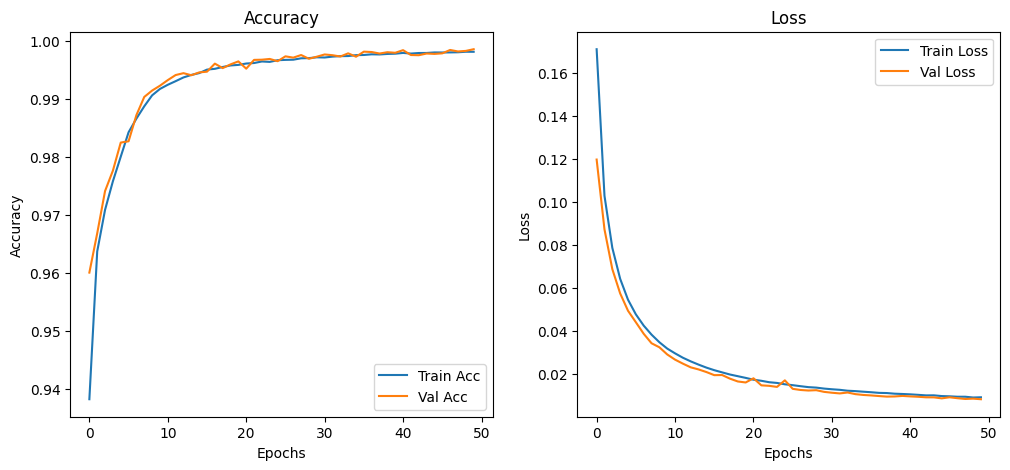

In [14]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()